# Quality Assessment Gene Expression Legionella Infection

In [97]:
import pandas
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data Frame

(41424, 25)


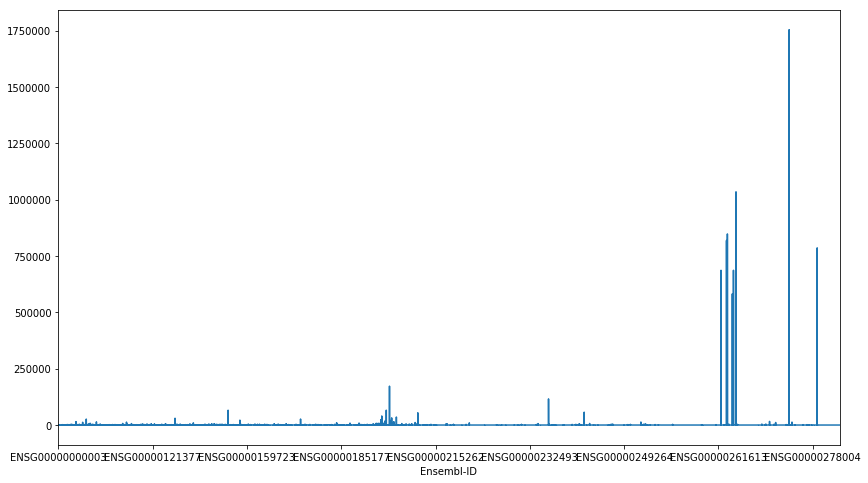

In [98]:
gene_expression = pandas.DataFrame.from_csv('normalized-counts-labels.csv',
                                            encoding='utf-8', sep=',')
#gene_expression = gene_expression.dropna()
ge_nonames = gene_expression.drop('Name', axis=1)
fig = plt.figure(figsize=(14, 8))
ge_nonames.mean(axis=1).plot()
print (gene_expression.shape)

### Preprocessing: Kick out genes whose expression is unrealistically high

In [87]:
threshold = ge_nonames.mean(axis=1).std()*10.
print ("Threshold Gene Expression: {}".format(threshold))
anomalies = gene_expression[ge_nonames.mean(axis=1) > threshold]
ge_anomalies_removed = ge_nonames.drop(anomalies.index)
ge_anomalies_removed.shape

Threshold Gene Expression: 134645.32488240575


(41415, 24)

### Preprocessing: Remove genes with many zeros

<IPython.core.display.Javascript object>


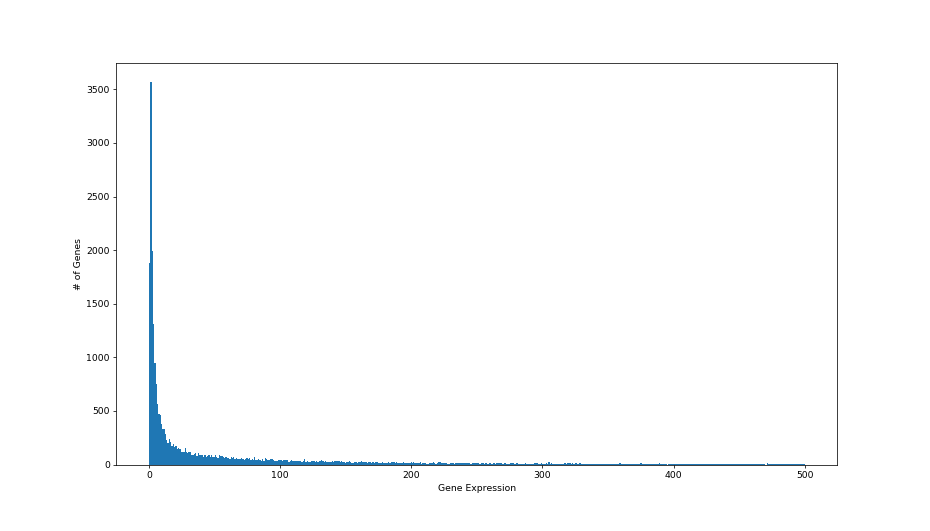

(115942.00231560237, 'ENSG00000234741')

In [88]:
ge_zeros_removed = ge_anomalies_removed[ge_anomalies_removed.astype('bool').mean(axis=1)>=.5]

fig = plt.figure(figsize=(14, 8))
bins = np.linspace(0, 500, 500)
ax = plt.hist(ge_zeros_removed.mean(axis=1), bins=bins)
plt.xlabel('Gene Expression')
plt.ylabel('# of Genes')
ge_zeros_removed.mean(axis=1).max(), ge_zeros_removed.mean(axis=1).argmax()

### Preprocessing: Scaling the gene expression over genes

In [4]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaled_features = scaler.fit_transform(ge_zeros_removed)
ge_scaled = pandas.DataFrame(scaled_features,
                             index=ge_zeros_removed.index,
                             columns=ge_zeros_removed.columns)
ge_scaled.shape

(26403, 24)

### Preprocessing: Remove low variance genes

Pam3T16        -0.018817
Pam3T8         -0.020233
Pam3T16.1      -0.017986
Pam3T8.1       -0.019444
Pam3T16.2      -0.019820
Pam3T8.2       -0.021065
ControlT8      -0.018800
ControlT16     -0.017669
ControlT8.1    -0.015749
ControlT16.1   -0.013547
ControlT8.2    -0.019255
ControlT16.2   -0.018879
gfpmT8         -0.017889
gfpmT16        -0.017878
gfpmT8.1       -0.016432
gfpmT16.1      -0.014456
gfpmT8.2       -0.018104
gfpmT16.2      -0.018697
gfppT8         -0.009528
gfppT16        -0.014393
gfppT8.1       -0.012976
gfppT16.1      -0.013769
gfppT8.2       -0.011114
gfppT16.2      -0.013468
Name: ENSG00000000419, dtype: float64

0.265799400315 ENSG00000244630


<IPython.core.display.Javascript object>


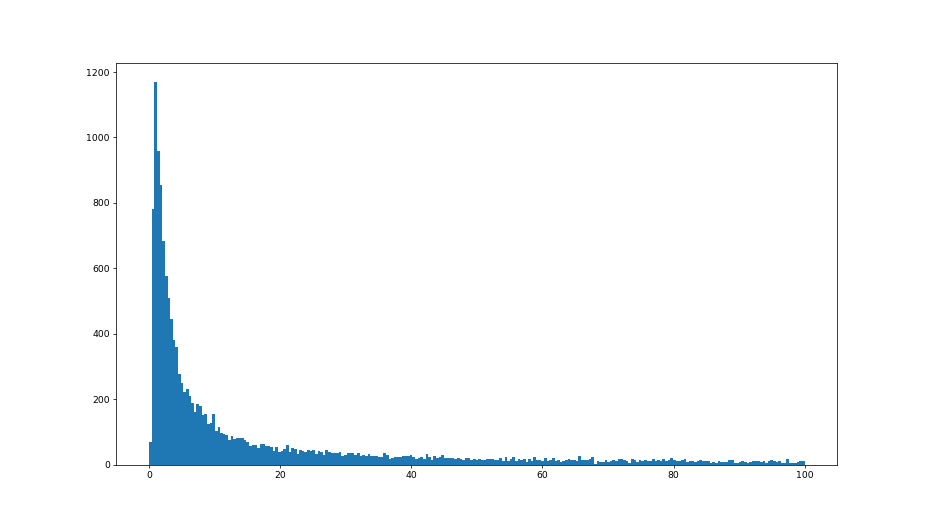

In [89]:
var_genes = ge_zeros_removed.var(axis=1)
print (var_genes.min(), var_genes.argmin())
threshold_percent = int((var_genes.shape[0] / 100.)*10)
highest_20_percent_var = var_genes.sort_values(ascending=False)[:threshold_percent]
ge_high_var = ge_scaled.loc[highest_20_percent_var.index]

fig = plt.figure(figsize=(14, 8))
bins = np.linspace(0, 100, 250)
h = plt.hist(var_genes, bins)

### PCA of genes

In [90]:
pca = PCA(n_components=5, whiten=True)
reduced = pca.fit_transform(ge_high_var)
reduced.shape

(2639, 5)

<IPython.core.display.Javascript object>


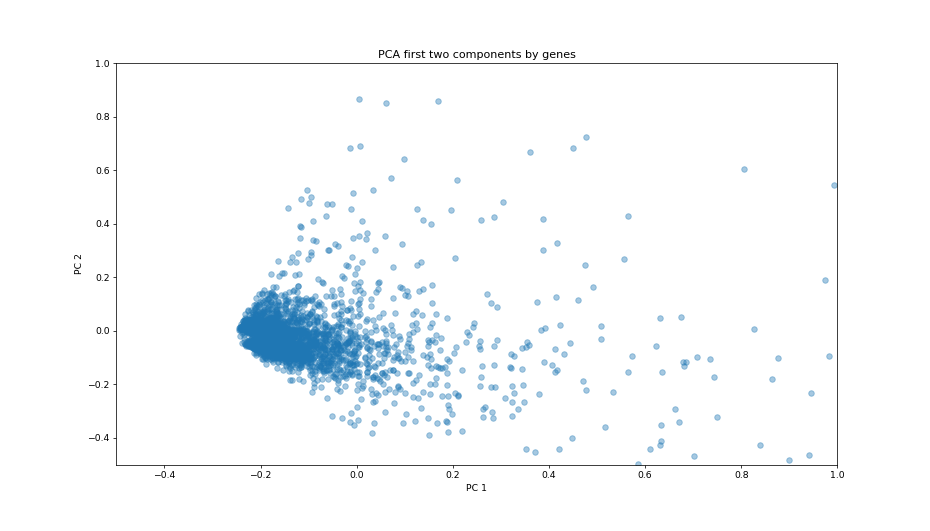

In [91]:
fig = plt.figure(figsize=(14, 8))
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.4)
plt.xlim([-.5, 1])
plt.ylim([-.5, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA first two components by genes')

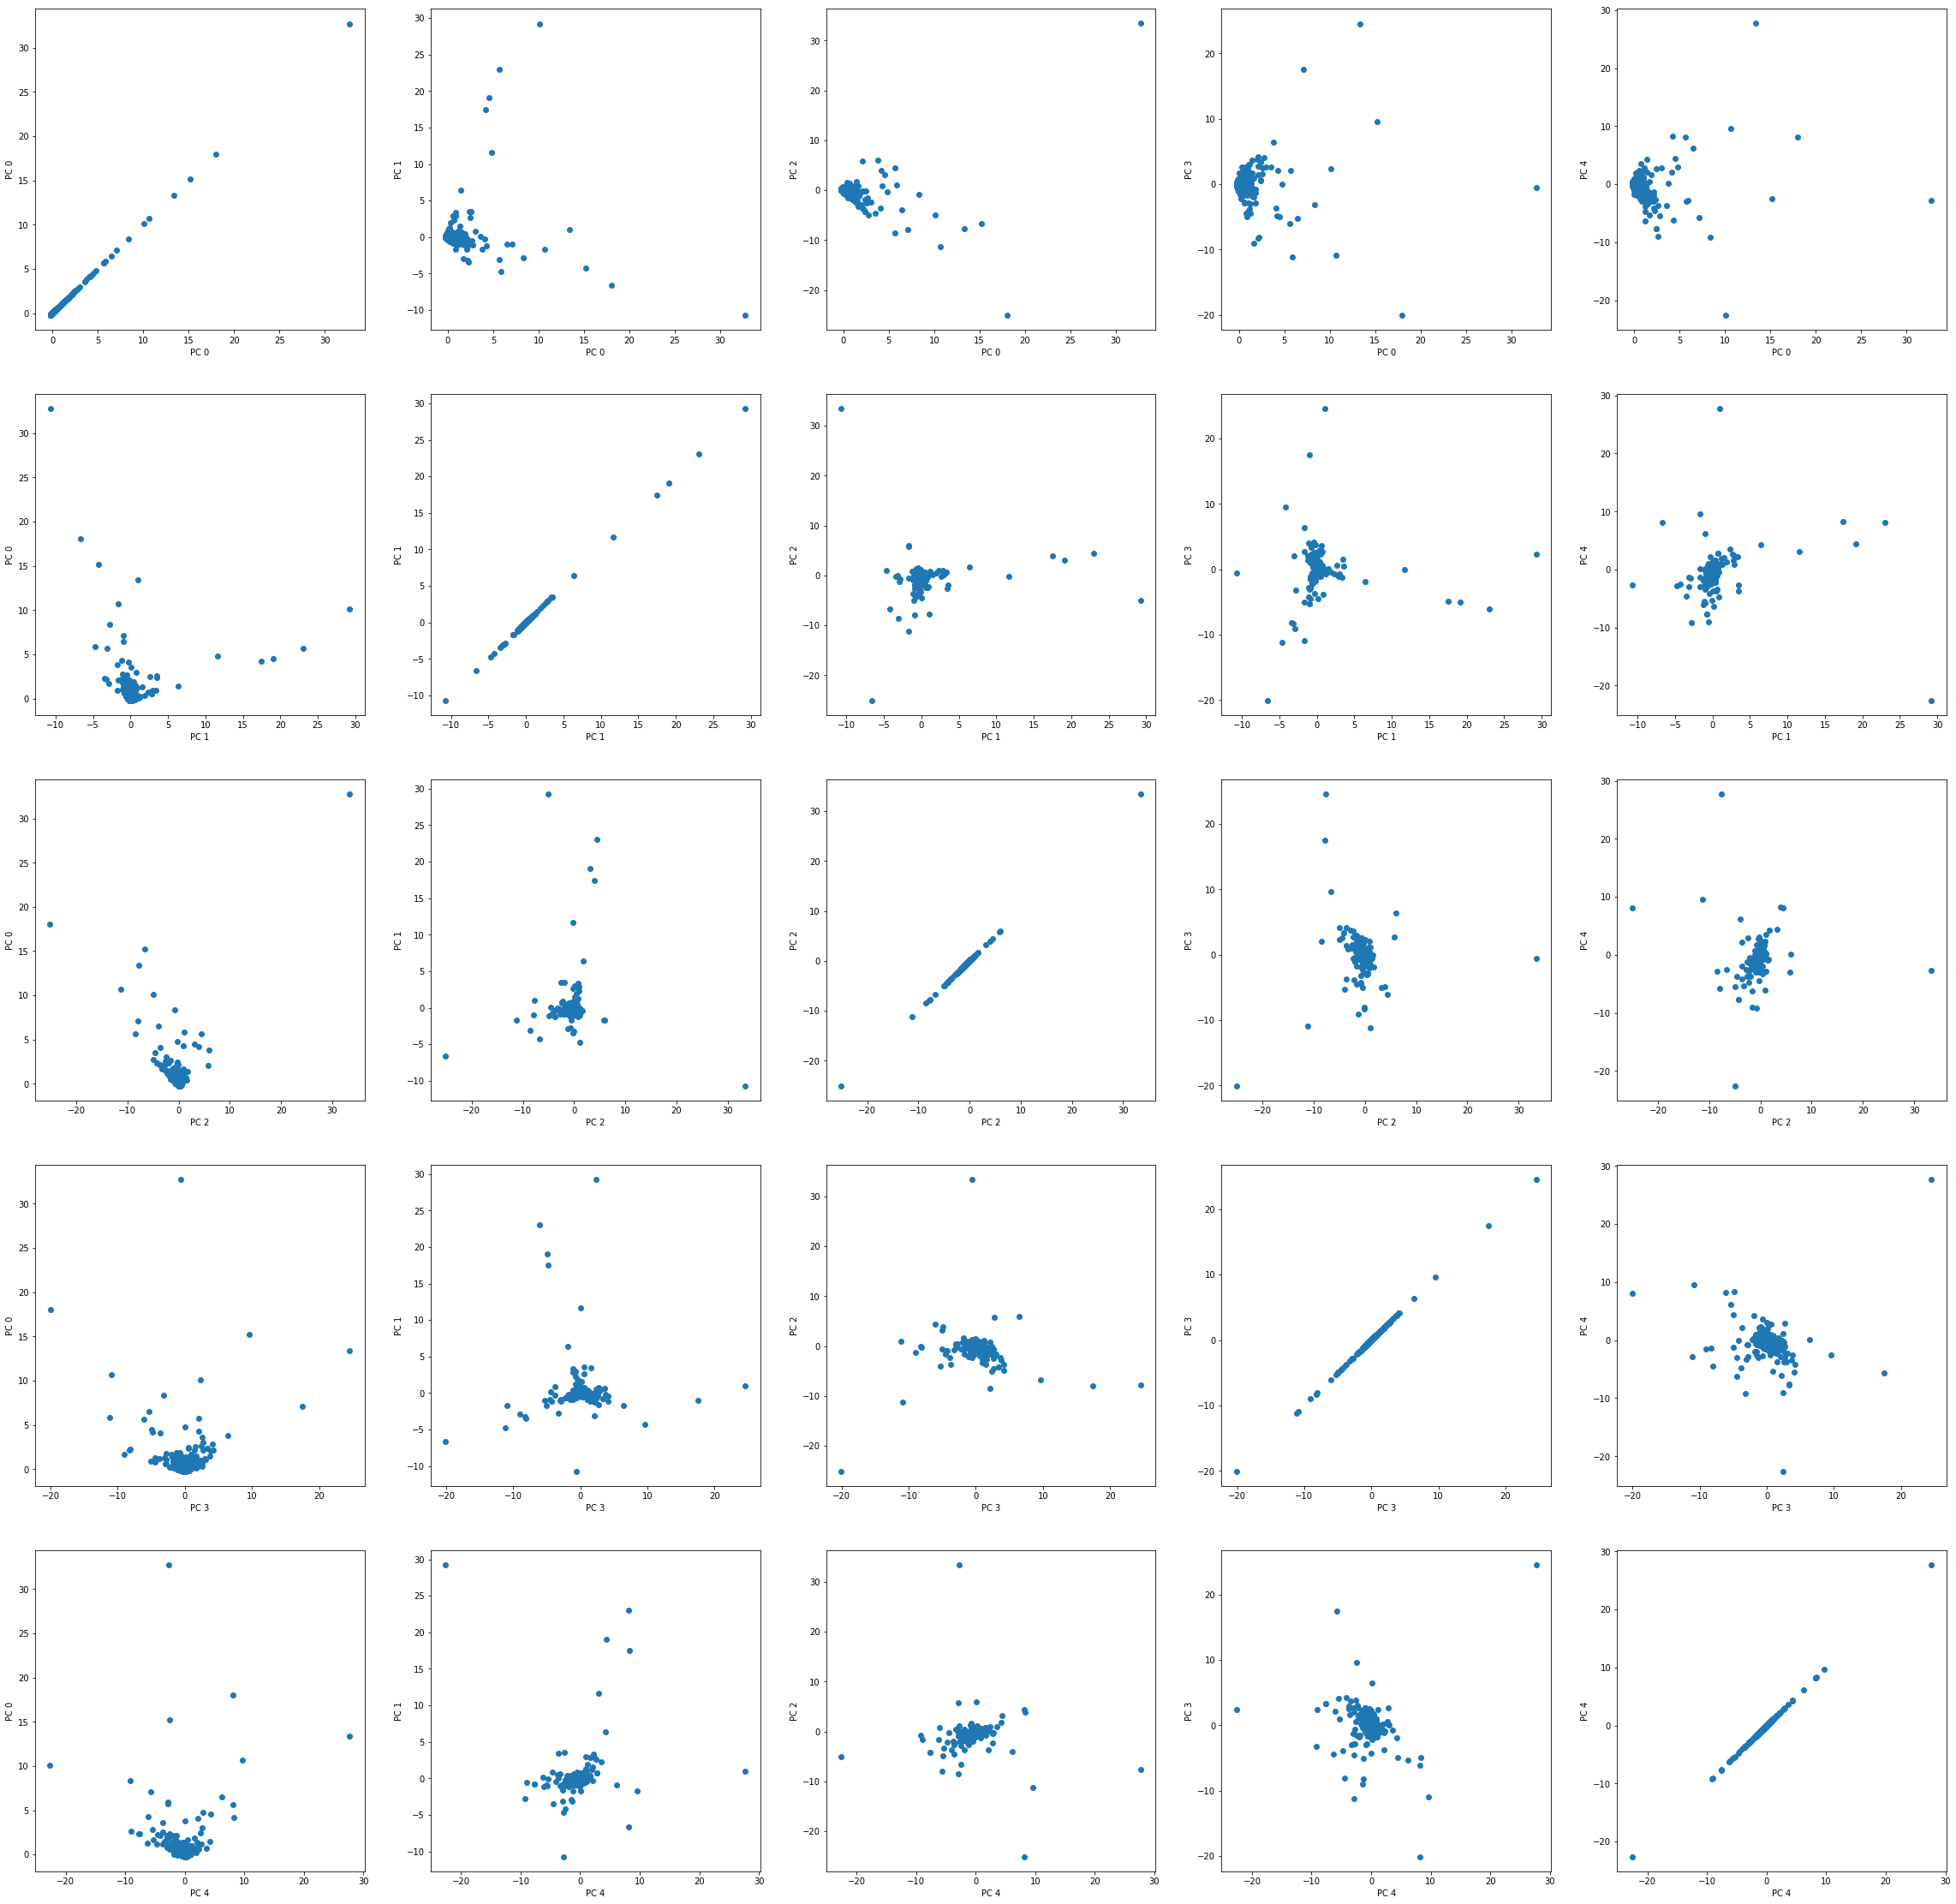

In [74]:
fig = plt.figure(figsize=(40, 40))
count = 1
for x in range(5):
    for y in range(5):
        plt.subplot(5, 5, count)
        plt.scatter(reduced[:, x], reduced[:, y])
        plt.xlabel('PC {}'.format(x))
        plt.ylabel('PC {}'.format(y))
        count += 1

## PCA of experiment type

In [92]:
pca2 = PCA(n_components=3, whiten=True)
pca_per_class = pca2.fit_transform(ge_high_var.transpose())
pca_per_class.shape

(24, 3)

<IPython.core.display.Javascript object>


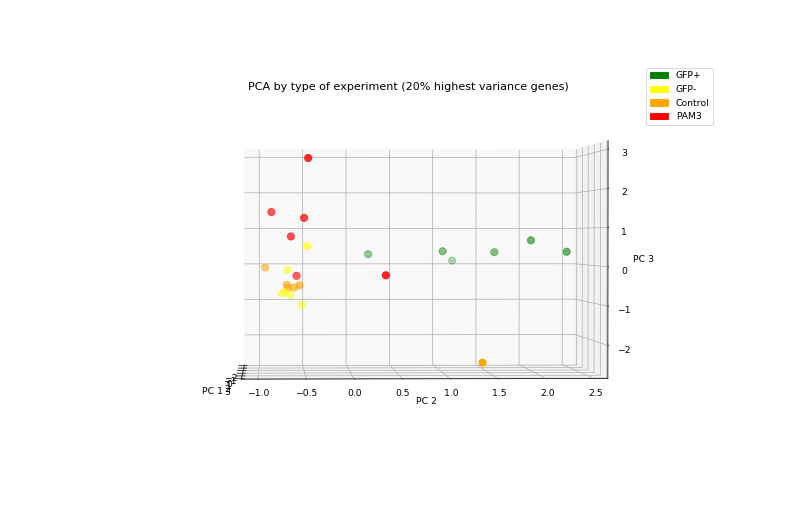

In [99]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
%matplotlib notebook
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# get colors for labels
colors = []
labels = []
for names in ge_nonames.transpose().index:
    if names.startswith('Control'):
        colors.append('orange')
        labels.append('Control')
    elif names.startswith('gfpp'):
        colors.append('green')
        labels.append('GFP+')
    elif names.startswith('gfpm'):
        colors.append('yellow')
        labels.append('GFP-')
    elif names.startswith('Pam'):
        colors.append('red')
        labels.append('Replicates')
    else:
        print ('Group {} not recognized'.format(names))

ax.scatter(pca_per_class[:, 0], pca_per_class[:, 1], pca_per_class[:, 2],
           c=colors, label=labels, s=60)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.title('PCA by type of experiment (20% highest variance genes)')

# legend
gfpp_patch = mpatches.Patch(color='green', label='GFP+')
gfpm_patch = mpatches.Patch(color='yellow', label='GFP-')
control_patch = mpatches.Patch(color='orange', label='Control')
replicate_patch = mpatches.Patch(color='red', label='PAM3')
plt.legend(handles=[gfpp_patch, gfpm_patch, control_patch, replicate_patch])

# annotate names
count = 0
for names in ge_nonames.transpose().index:
    plt.annotate(names, (pca_per_class[count, 0], pca_per_class[count, 1]))
    count += 1

#fig.savefig('pca_by_types.png', dpi=300)

## Get Loadings per Experiment Type

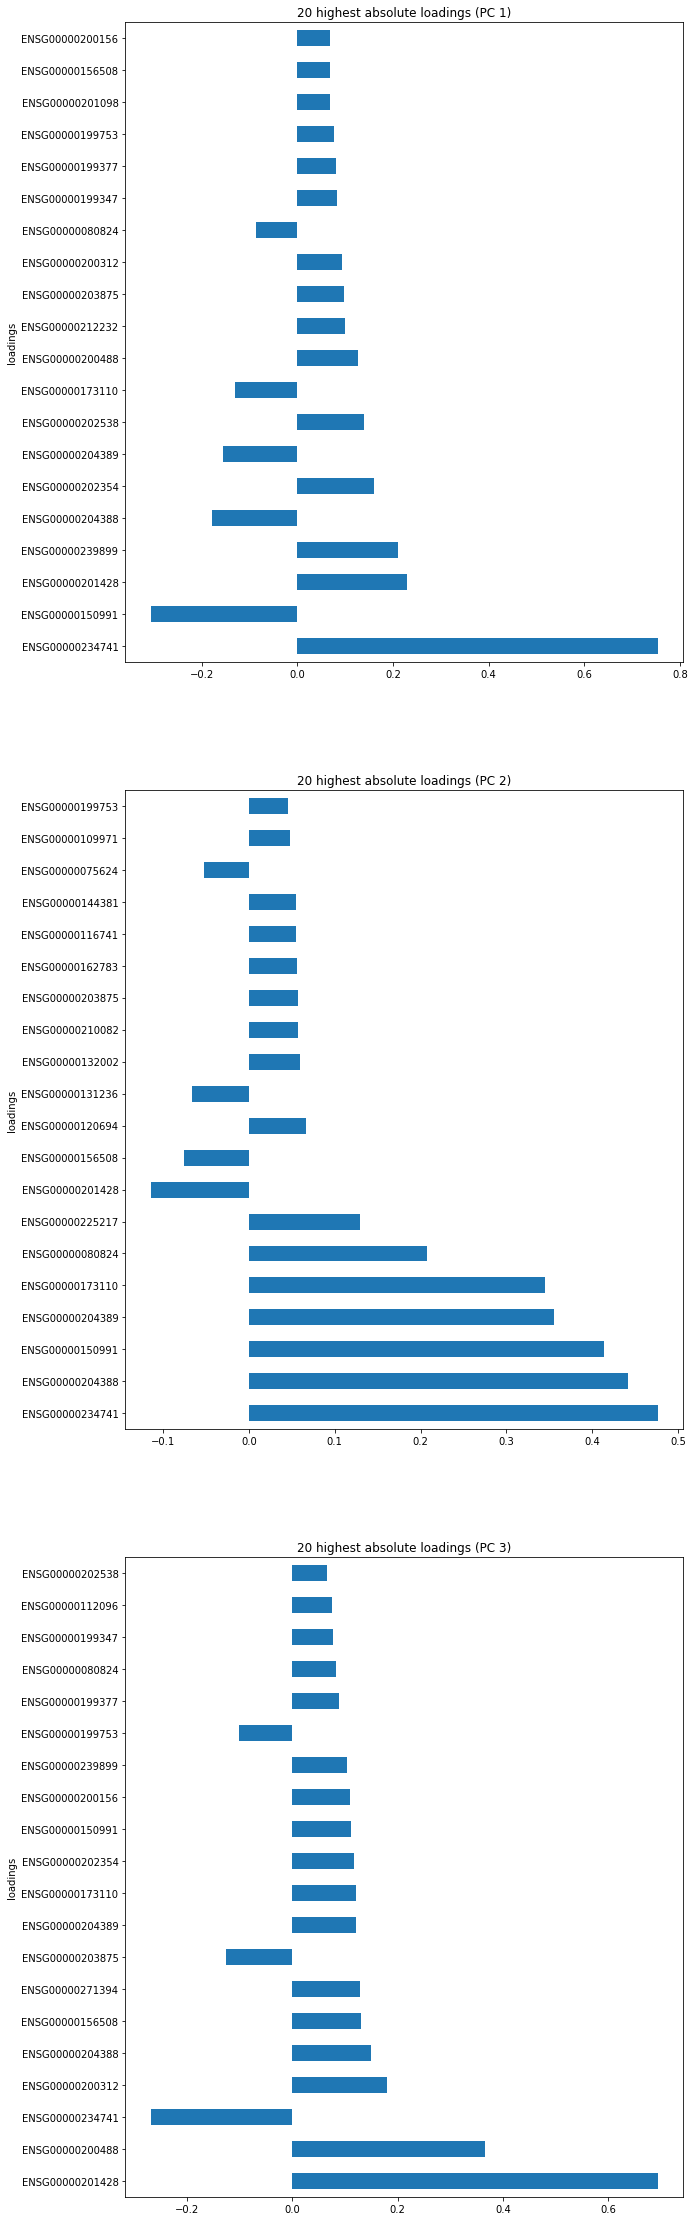

In [172]:
fig = plt.figure(figsize=(10, 40))
for comp in range(pca2.n_components):
    ax = plt.subplot(3, 1, comp+1)
    loadings = pca2.components_[comp]
    loading_df = pandas.DataFrame(loadings, index=ge_high_var.index)
    loading_df['sort'] = loading_df.abs()
    top_20_loadings_df = loading_df.sort_values(by='sort', ascending=False)[:20]
    top_20_loadings_df = top_20_loadings_df.drop('sort', axis=1)
    top_20_loadings_df.plot(kind='barh',
                                 legend=False,
                                 title='20 highest absolute loadings (PC {})'.format(comp+1),
                                 ax=ax
                                )
    ax.set_ylabel('loadings')
fig.savefig('loadings_pca.png', dpi=300)

In [171]:
loadings = pca2.components_.T
print (ge_high_var.index.shape)
print (loadings.shape)
loadings_df = pandas.DataFrame(loadings, index=ge_high_var.index.tolist())

(2639,)
(2639, 3)
